# DeepSphere using SHREC17 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721)
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [4]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from SHREC17.load_shrec import fix_dataset, Shrec17Dataset, Shrec17DatasetCache

## 0.2 Define parameters

In [4]:
bw = 64
experiment = 'equiangular'
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/shrec17/' # localisation of the .obj files

In [5]:
sigma_noise = 0
noise_dataset = True    # use perturbed dataset (Cohen and Esteves do the same)
augmentation = 1        # number of element per file (1 = no augmentation of dataset)

## 1 Load dataset

In [6]:
# if datasets are already downloaded but not preprocessed
fix = False
if fix:
    fix_dataset(datapath+'val_perturbed')
    fix_dataset(datapath+'test_perturbed')

download dataset if True, preprocess data and store it in npy files, and load it in a dataset object

In [7]:
download = False
train_dataset = Shrec17Dataset(datapath, 'train', perturbed=noise_dataset, download=download, nside=bw, 
                                    augmentation=augmentation, nfile=None, experiment = experiment)


31364it [00:38, 811.16it/s]


In [8]:
val_dataset = Shrec17Dataset(datapath, 'val', perturbed=noise_dataset, download=download, nside=bw, 
                                 augmentation=augmentation, nfile=None, experiment = experiment)

5133it [00:07, 690.13it/s]


## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

Number of elements / class


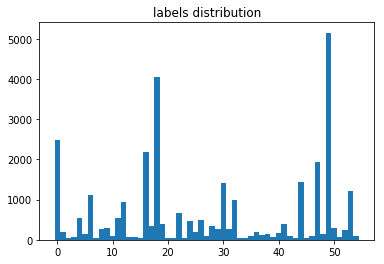

In [9]:
# Not necessary if datasetCache is used
x_train, labels_train, ids_train = train_dataset.return_data(train=True, train_ratio=1.)

In [10]:
nclass = train_dataset.nclass
num_elem = train_dataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem,'\nfirst id:',ids_train[0])

number of class: 55 
number of elements: 31364 
first id: 010507


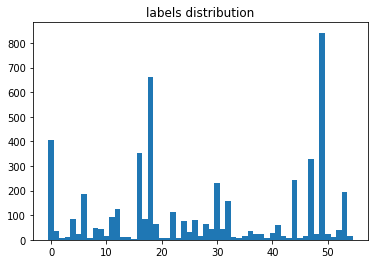

In [11]:
x_val, labels_val, ids_val = val_dataset.return_data(train=False)

#### Plot sphere images

Show what the projection looks like for the first two features

In [12]:
im1 = x_train[0,:,0]
im0003 = train_dataset.data[0,:,0]
im1_norm = x_train[0,:,1]
im0003_norm = train_dataset.data[0,:,1]
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.min(x_train[:,:,0])
cmax = np.max(x_train[:,:,0])
cmin_norm = np.min(x_train[:,:,1])
cmax_norm = np.max(x_train[:,:,1])

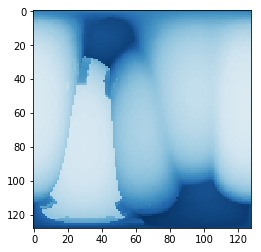

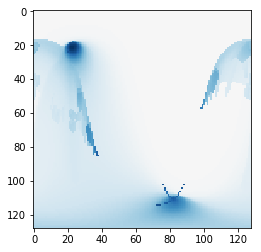

In [13]:
plt.imshow(im1.reshape((2*bw,2*bw)), cmap=cm, vmin = cmin, vmax = cmax)
plt.figure()
plt.imshow(im0003.reshape((2*bw,2*bw)), cmap=cm, vmin = cmin, vmax = cmax)

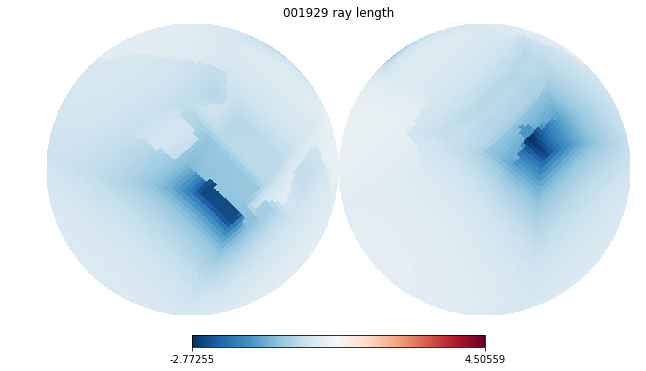

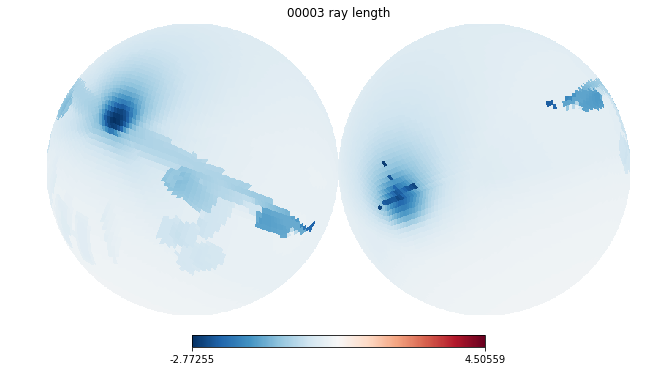

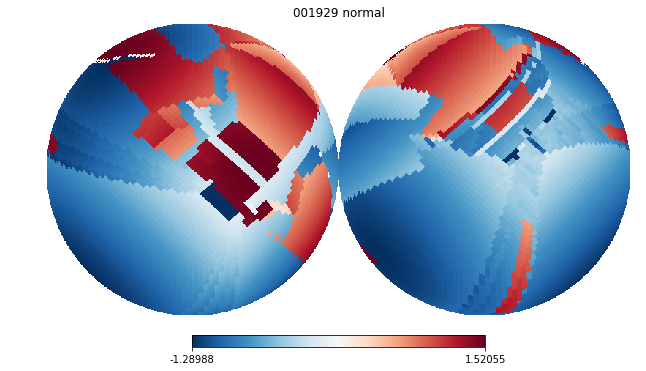

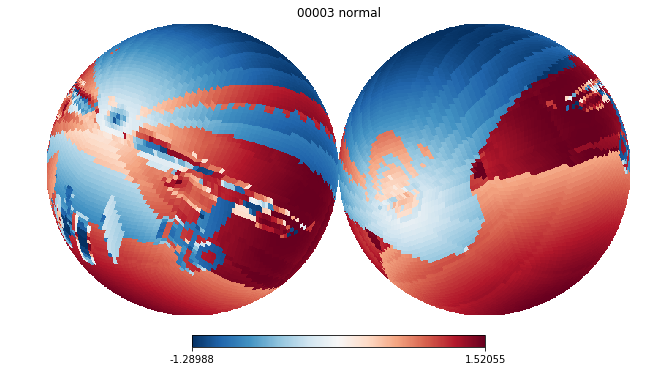

In [16]:
# hp.orthview(im1, title=ids_train[0]+" ray length", nest=True, cmap=cm, min=cmin, max=cmax)
# hp.orthview(im0003, rot=(90,90,290), title='00003 ray length', nest=True, flip='geo', cmap=cm, min=cmin, max=cmax)
# hp.orthview(im1_norm, title=ids_train[0]+" normal", nest=True, cmap=cm, min=cmin_norm, max=cmax_norm)
# hp.orthview(im0003_norm, rot=(90,90,290), title='00003 normal', nest=True, flip='geo', cmap=cm, min=cmin_norm, max=cmax_norm)

## 2 Classification using DeepSphere

Use of the Dataset object used for other DeepSphere experiments

In [14]:
training = LabeledDataset(x_train, labels_train)
validation = LabeledDataset(x_val, labels_val)

In [15]:
EXP_NAME = 'shrec17_equiangular_SGD_max_bw_{}bw{}'.format(bw, ename)
#EXP_NAME = "shrec17_40sim_32sides_0noise_FCN"
#EXP_NAME = 'plop'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [16]:
params = hyperparameters.get_params_shrec17_equiangular(num_elem, EXP_NAME, nclass, architecture=experiment_type)
model = models.deepsphere(**params)

bandwidth: 64
#pixels: [16384, 1024, 400]
#samples per batch: 32
=> #pixels per batch (input): 524,288
=> #pixels for training (input): 51,386,777,600
Learning rate will start at 5.0e-01 and finish at 5.0e-01.
NN architecture
  input: M_0 = 16384
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 16384 * 100 / 16 = 102400
    weights: F_0 * F_1 * K_1 = 6 * 100 * 64 = 38400
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 1024 * 100 / 1 = 102400
    weights: F_1 * F_2 * K_2 = 100 * 100 * 16 = 160000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500


In [40]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [18]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, training.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(training, validation)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 100 / 16 = 76800
    weights: F_0 * F_1 * K_1 = 6 * 100 * 56 = 33600
    biases: F_1 = 100
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 768 * 100 / 4 = 19200
    weights: F_1 * F_2 * K_2 = 100 * 100 * 13 = 130000
    biases: F_2 = 100
    batch normalization
  Statistical layer: mean
    representation: 1 * 100 = 100
  layer 3: logits (softmax)
    representation: M_3 = 55
    weights: M_2 * M_3 = 100 * 55 = 5500
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.35e+00


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.45 (23 / 5133), f1 (weighted): 0.28, loss: 4.20e+00
  CPU time: 247s, wall time: 976s, perf_time: 0.62s
step 2940 / 19602 (epoch 3.00 / 20):
  learning_rate = 3.16e-05, training loss = 3.72e+00
  validation accuracy: 3.37 (173 / 5133), f1 (weighted): 2.86, loss: 3.97e+00
  CPU time: 470s, wall time: 1889s, perf_time: 0.56s
step 4410 / 19602 (epoch 4.50 / 20):
  learning_rate = 1.78e-04, training loss = 3.29e+00
  validation accuracy: 31.09 (1596 / 5133), f1 (weighted): 19.99, loss: 3.17e+00
  CPU time: 686s, wall time: 2769s, perf_time: 0.57s
step 5880 / 19602 (epoch 6.00 / 20):
  learning_rate = 9.98e-04, training loss = 2.18e+00
  validation accuracy: 45.22 (2321 / 5133), f1 (weighted): 33.98, loss: 2.36e+00
  CPU time: 901s, wall time: 3648s, perf_time: 0.56s
step 7350 / 19602 (epoch 7.50 / 20):
  learning_rate = 5.61e-03, training loss = 1.69e+00
  validation accuracy: 57.72 (2963 / 5133), f1 (weighted): 50.28, loss: 1.77e+00
  CPU time: 1118s, wall time: 4

KeyboardInterrupt: 

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [41]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
logits/weights:0
the number of parameters in the model is: 204,100


In [43]:
accuracy_validation, loss_validation, loss_training, t_step = model.fit(training, validation, use_tf_dataset=False)

step 490 / 98012 (epoch 0.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.79e-01


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 62.19 (3192 / 5133), f1 (weighted): 57.88, loss: 1.48e+00
  CPU time: 183s, wall time: 567s, perf_time: 1.00s
step 980 / 98012 (epoch 1.00 / 100):
  learning_rate = 5.00e-01, training loss = 6.44e-01
  validation accuracy: 69.10 (3547 / 5133), f1 (weighted): 66.44, loss: 1.19e+00
  CPU time: 358s, wall time: 1126s, perf_time: 0.99s
step 1470 / 98012 (epoch 1.50 / 100):
  learning_rate = 5.00e-01, training loss = 2.84e-01
  validation accuracy: 67.15 (3447 / 5133), f1 (weighted): 64.35, loss: 1.31e+00
  CPU time: 535s, wall time: 1688s, perf_time: 1.00s
step 1960 / 98012 (epoch 2.00 / 100):
  learning_rate = 5.00e-01, training loss = 5.66e-01
  validation accuracy: 70.99 (3644 / 5133), f1 (weighted): 68.92, loss: 1.13e+00
  CPU time: 709s, wall time: 2246s, perf_time: 1.01s
step 2450 / 98012 (epoch 2.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.79e-01
  validation accuracy: 70.02 (3594 / 5133), f1 (weighted): 67.80, loss: 1.20e+00
  CPU time: 881s, wal

step 18620 / 98012 (epoch 19.00 / 100):
  learning_rate = 5.00e-01, training loss = 2.04e-01
  validation accuracy: 74.34 (3816 / 5133), f1 (weighted): 72.97, loss: 1.07e+00
  CPU time: 5558s, wall time: 23698s, perf_time: 0.99s
step 19110 / 98012 (epoch 19.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.40e-01
  validation accuracy: 75.45 (3873 / 5133), f1 (weighted): 74.17, loss: 1.06e+00
  CPU time: 5735s, wall time: 24261s, perf_time: 1.01s
step 19600 / 98012 (epoch 20.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.28e-01
  validation accuracy: 74.28 (3813 / 5133), f1 (weighted): 72.66, loss: 1.05e+00
  CPU time: 5908s, wall time: 24821s, perf_time: 0.99s
step 20090 / 98012 (epoch 20.50 / 100):
  learning_rate = 5.00e-01, training loss = 3.13e-01
  validation accuracy: 75.30 (3865 / 5133), f1 (weighted): 74.00, loss: 1.06e+00
  CPU time: 6082s, wall time: 25381s, perf_time: 1.00s
step 20580 / 98012 (epoch 21.00 / 100):
  learning_rate = 5.00e-01, training loss = 

step 36260 / 98012 (epoch 37.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.77e-01
  validation accuracy: 73.58 (3777 / 5133), f1 (weighted): 72.70, loss: 1.13e+00
  CPU time: 11873s, wall time: 43881s, perf_time: 1.01s
step 36750 / 98012 (epoch 37.50 / 100):
  learning_rate = 5.00e-01, training loss = 4.14e-01
  validation accuracy: 75.67 (3884 / 5133), f1 (weighted): 74.62, loss: 1.13e+00
  CPU time: 12049s, wall time: 44441s, perf_time: 1.01s
step 37240 / 98012 (epoch 38.00 / 100):
  learning_rate = 5.00e-01, training loss = 1.11e-01
  validation accuracy: 75.34 (3867 / 5133), f1 (weighted): 74.67, loss: 1.08e+00
  CPU time: 12223s, wall time: 45001s, perf_time: 1.01s
step 37730 / 98012 (epoch 38.50 / 100):
  learning_rate = 5.00e-01, training loss = 2.38e-01
  validation accuracy: 75.41 (3871 / 5133), f1 (weighted): 74.38, loss: 1.14e+00
  CPU time: 12398s, wall time: 45561s, perf_time: 1.00s
step 38220 / 98012 (epoch 39.00 / 100):
  learning_rate = 5.00e-01, training los

step 53900 / 98012 (epoch 54.99 / 100):
  learning_rate = 5.00e-01, training loss = 6.62e-02
  validation accuracy: 75.30 (3865 / 5133), f1 (weighted): 74.22, loss: 1.17e+00
  CPU time: 18199s, wall time: 64062s, perf_time: 1.00s
step 54390 / 98012 (epoch 55.49 / 100):
  learning_rate = 5.00e-01, training loss = 8.33e-02
  validation accuracy: 73.25 (3760 / 5133), f1 (weighted): 73.56, loss: 1.34e+00
  CPU time: 18375s, wall time: 64623s, perf_time: 1.00s
step 54880 / 98012 (epoch 55.99 / 100):
  learning_rate = 5.00e-01, training loss = 5.28e-02
  validation accuracy: 75.73 (3887 / 5133), f1 (weighted): 74.66, loss: 1.14e+00
  CPU time: 18551s, wall time: 65184s, perf_time: 0.99s
step 55370 / 98012 (epoch 56.49 / 100):
  learning_rate = 5.00e-01, training loss = 9.83e-02
  validation accuracy: 74.77 (3838 / 5133), f1 (weighted): 75.15, loss: 1.24e+00
  CPU time: 18726s, wall time: 65745s, perf_time: 1.00s
step 55860 / 98012 (epoch 56.99 / 100):
  learning_rate = 5.00e-01, training los

KeyboardInterrupt: 

In [ ]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [44]:
model.evaluate(x_train, labels_train)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 84.63 (26543 / 31364), f1 (weighted): 84.40, loss: 5.35e-01\nCPU time: 457s, wall time: 426s',
 84.62887386812906,
 84.39665039145795,
 0.5352089285314607)

In [ ]:
#predictions, loss = model.predict(x_val, labels_val)

In [19]:
model.evaluate(x_val, labels_val)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 74.48 (3823 / 5133), f1 (weighted): 73.56, loss: 1.26e+00\nCPU time: 73s, wall time: 69s',
 74.47886226378337,
 73.55537431140489,
 1.2610648227857377)

In [17]:
probabilities = model.probs(x_val, nclass)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    ids_val = ids_val[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


In [ ]:
#predictions = predictions.astype(np.int)

In [18]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_equiangular_SGD/val_perturbed'), exist_ok=True)
for i,_id in enumerate(ids_val):
    idfile = os.path.join(datapath,'results_equiangular_SGD/val_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_val[j]) for j in range(len(ids_val)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

NaN appears if remove i==j case

## test network

In [10]:
download = False

In [20]:
test_dataset = Shrec17Dataset(datapath, 'test', perturbed=noise_dataset, download=download, nside=bw, 
                              augmentation=augmentation, nfile=None, experiment=experiment)

10265it [00:23, 429.91it/s]


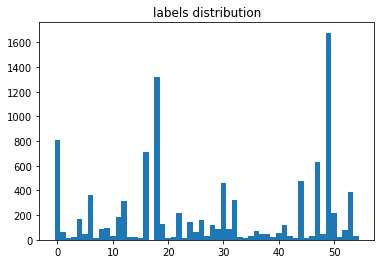

In [21]:
x_test, labels_test, ids_test = test_dataset.return_data(train=False)

In [22]:
model.evaluate(x_test, labels_test)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


('accuracy: 69.43 (7127 / 10265), f1 (weighted): 69.35, loss: 1.49e+00\nCPU time: 148s, wall time: 137s',
 69.43010228933268,
 69.34914950241057,
 1.494190350684432)

In [ ]:
#predictions = model.predict(x_test)

In [23]:
probabilities = model.probs(x_test, nclass)
#probabilities = np.log(probabilities)
if augmentation>1:
    probabilities = probabilities.reshape((-1,augmentation,nclass))
    probabilities = probabilities.mean(axis=1)
    ids_test = ids_test[::repeat]
predictions = np.argmax(probabilities, axis=1)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/shrec17_equiangular_SGD_max_bw_64bw_CNN/model-69580


In [ ]:
#predictions = predictions.astype(np.int)

write to file

In [24]:
# for every file, find every object with the same class, sorted by most relevance
os.makedirs(os.path.join(datapath,'results_equiangular_SGD/test_perturbed'), exist_ok=True)
for i, _id in enumerate(ids_test):
    idfile = os.path.join(datapath,'results_equiangular_SGD/test_perturbed',_id)
    # predictions batchxclass
    # pred_class batch == predictions
    retrieved = [(probabilities[j, predictions[j]], ids_test[j]) for j in range(len(ids_test)) if predictions[j] == predictions[i]]
    retrieved = sorted(retrieved, reverse=True)
    retrieved = [i for _, i in retrieved]
    with open(idfile, "w") as f:
        f.write("\n".join(retrieved))

Why not working?

In [44]:
def _print_histogram(nclass, labels_train, labels_val=None):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    #plt.xticks(indexes + width * 0.5, labels)
    if labels_val is not None:
        hist_val=Counter(labels_val)
        plt.figure()
        labels, values = zip(*hist_val.items())
        indexes = np.asarray(labels)
        width = 1
        plt.bar(indexes, values, width)
        plt.title("validation labels distribution")
    plt.show()

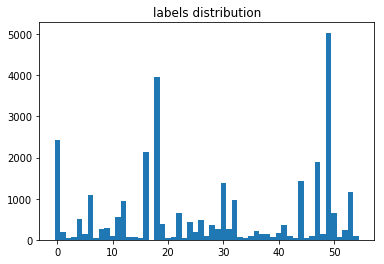

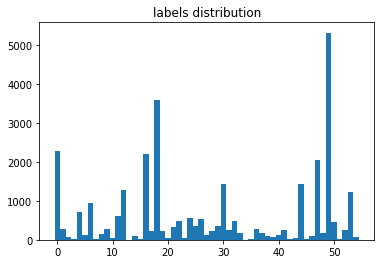

In [45]:
_print_histogram(55, labels_test)
_print_histogram(55, predictions)

In [25]:
del test_dataset
del train_dataset
del val_dataset

In [22]:
import tensorflow as tf
tf.reset_default_graph()

### Build Equiangular weight matrix

In [170]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
import os
import sys
import hashlib
import zipfile

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import healpy as hp

In [162]:
def spherical2cartesian(angles, radius=1, radians=True):
    """Transform spherical coordinates to cartesian coordinates.
    
    Parameters
    ----------
    angles : array-like, n_points x n_dimensions
        Sphere S^n_angles embedded in R^{n_angles + 1}.
        Angles 0 to n_angles-2 range over [0,π] radians ([0,180] degrees).
        The last angle ranges over [0,2π) ([0,360] degrees).
    radius : int
    radians : bul
        True if the angles are in radians, False if they are in degrees.
    
    Returns
    -------
    positions : ndarray, n_points x n_dimensions-1
    
    """
    angles = np.asarray(angles)
    n_points, n_dimensions = angles.shape
    if not radians:
        angles = np.deg2rad(angles)
    positions = np.empty((n_points, n_dimensions+1))
    positions[:, 0] = radius * np.ones(n_points)
    for d in range(n_dimensions):
        positions[:, d+1] = positions[:, d] * np.sin(angles[:, d])
        positions[:, d] *= np.cos(angles[:, d])
    return positions

In [164]:
beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
alpha = np.arange(2 * bw) * np.pi / bw

ct = np.cos(beta)
st = np.sin(beta)
cp = np.cos(alpha)
sp = np.sin(alpha)
x = st * cp
y = st * sp
z = ct
coords = np.vstack([x.flatten(), y.flatten(), z.flatten()]).transpose() 

In [166]:
coords

array([[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 2.70598050e-01,  2.70598050e-01,  9.23879533e-01],
       [ 4.32978028e-17,  7.07106781e-01,  7.07106781e-01],
       [-6.53281482e-01,  6.53281482e-01,  3.82683432e-01],
       [-1.00000000e+00,  1.22464680e-16,  6.12323400e-17],
       [-6.53281482e-01, -6.53281482e-01, -3.82683432e-01],
       [-1.29893408e-16, -7.07106781e-01, -7.07106781e-01],
       [ 2.70598050e-01, -2.70598050e-01, -9.23879533e-01]])

In [170]:
np.vstack([beta,alpha]).shape

(2, 8)

In [172]:
coords_mdeff=spherical2cartesian(np.vstack([beta,alpha]).T)

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.23879533e-01,  2.70598050e-01,  2.70598050e-01],
       [ 7.07106781e-01,  4.32978028e-17,  7.07106781e-01],
       [ 3.82683432e-01, -6.53281482e-01,  6.53281482e-01],
       [ 6.12323400e-17, -1.00000000e+00,  1.22464680e-16],
       [-3.82683432e-01, -6.53281482e-01, -6.53281482e-01],
       [-7.07106781e-01, -1.29893408e-16, -7.07106781e-01],
       [-9.23879533e-01,  2.70598050e-01, -2.70598050e-01]])

In [174]:
coords == coords_mdeff[:,[1,2,0]]

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [78]:
def equiangular_weightmatrix(bw=64, indexes=None, dtype=np.float32):
    # define a way to read the grid
    if indexes is None:
        indexes = range((2*bw)**2)
    npix = len(indexes)#-(2*bw-1)  # Number of pixels.
    
    # Find a mean to take only indexes from grid
    beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
    alpha = np.arange(2 * bw) * np.pi / bw
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta)
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x.flatten(), y.flatten(), z.flatten()]).transpose() 
    coords = np.asarray(coords, dtype=dtype)
    
    
    def south(x, bw):
        if x >= (2*bw)*(2*bw-1):
            return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
        else:
            return x + 2*bw
        
    def north(x, bw):
        if x < 2*bw:
            return south((x+bw)%(2*bw),bw)
        else:
            return x - 2*bw
        
    def west(x, bw):
        if x%(2*bw)==0:
            x += 2*bw
        return x -1
    
    def east(x, bw):
        if x%(2*bw)==2*bw-1:
            x -= 2*bw
        return x + 1
        
    neighbors = []
    col_index=[]
    for ind in indexes:
        # first line is the same point, so is connected to all points of second line
        if ind < 2* bw:
            if ind == 0:
                neighbor = np.arange(1,4*bw)#np.arange(2*bw)+2*bw
            else:
                neighbor = [0]
        elif ind < 4*bw:
            neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
            neighbor += [0]#list(range(2*bw))
            #print(neighbor)
        else:
            neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                        north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
        neighbors.append(neighbor)
        col_index += list(neighbor)
    # neighbors = np.asarray(neighbors)
    col_index = np.asarray(col_index)
    
    #col_index = neighbors.reshape((-1))
    row_index = np.hstack([np.repeat(indexes[0], 2*bw+(2*bw-1)), indexes[1:2*bw], np.repeat(indexes[2*bw:4*bw], 6),#2*bw+5), 
                          np.repeat(indexes[4*bw:], 8)])
    
    distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
    # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2

    # Compute similarities / edge weights.
    kernel_width = np.mean(distances)
    weights = np.exp(-distances / (2 * kernel_width))
    #weights[1:2*bw]=0
    

    # Similarity proposed by Renata & Pascal, ICCV 2017.
    # weights = 1 / distances

    # Build the sparse matrix.
    W = sparse.csr_matrix(
        (weights, (row_index, col_index)), shape=(npix, npix), dtype=dtype)
    
    return W

In [ ]:
class healpix_graph(pygsp.Graphs):
    def __init__(self, plotting, coords, **kwargs):
        super(healpix_graph, self).__init__(W=W, plotting=plotting,
                                      coords=Xout, **kwargs)

In [79]:
mat = equiangular_weightmatrix(4)

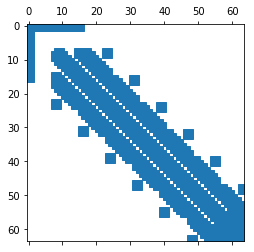

In [80]:
plt.spy(mat)

In [6]:
bw = 4
indexes = range((2*bw)**2)
np.asarray(indexes).reshape((-1, 2*bw))

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55],
       [56, 57, 58, 59, 60, 61, 62, 63]])

In [3]:
from deepsphere.utils import *

In [92]:
build_laplacians([64, 32, 16, 8, 8], indexes=None, use_4=False, sampling='equiangular')

([<16384x16384 sparse matrix of type '<class 'numpy.float32'>'
  	with 146558 stored elements in Compressed Sparse Row format>,
  <4096x4096 sparse matrix of type '<class 'numpy.float32'>'
  	with 36414 stored elements in Compressed Sparse Row format>,
  <1024x1024 sparse matrix of type '<class 'numpy.float32'>'
  	with 8990 stored elements in Compressed Sparse Row format>,
  <256x256 sparse matrix of type '<class 'numpy.float32'>'
  	with 2190 stored elements in Compressed Sparse Row format>],
 [4, 4, 4, 1])

In [237]:
G = equiangular_graph(bw=2)

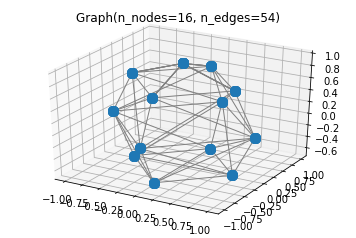

In [238]:
G.plot()

In [239]:
W = G.W

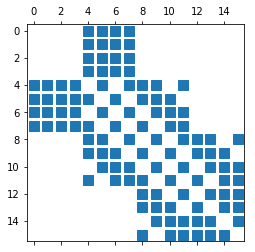

In [240]:
plt.spy(W)

In [153]:
degree = G.d
weight_degree = G.dw

(array([16128.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   256.]),
 array([  8. ,  20.5,  33. ,  45.5,  58. ,  70.5,  83. ,  95.5, 108. ,
        120.5, 133. ]),
 <a list of 10 Patch objects>)

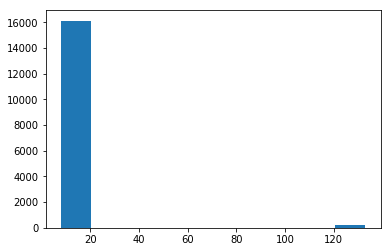

In [154]:
plt.hist(sorted(degree, reverse=True))

(array([ 128.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 1792., 1024.,  512.,  768.,  256.,  512.,  512.,
         256.,  512.,  256.,  256.,  256.,  256.,  512.,  256.,  256.,
         256.,  256.,  256.,  256.,  256.,  256.,    0.,  256.,  256.,
         256.,  256.,  256.,  256.,  256.,  256.,  256.,  256.,  256.,
         256.,  512.,  256.,  256.,  512.,  512.,  768.,  512.,    0.,
           0.,    0.,    0.,    0.,    0.,  128.]),
 array([2.98932171, 3.06284118, 3.13636065, 3.20988011, 3.28339958,
        3.35691905, 3.43043852, 3.50395799, 3.57747746, 3.65099692,
        3.72451639, 3.79803586, 3.87155533, 3.9450748 , 4.01859426,
        4.09211373, 4.1656332 , 4.23915267, 4.31267214, 4.38619161,
        4.45971107, 4.53323054, 4.60675001, 4.68026948, 4.75378895,
        4.82730842, 4.90082788, 4.97434735, 5.04786682, 5.12138629,
        5.19490576, 5.26842523, 5.34194469, 5.41546416, 5.48898363,
        5.5625031 , 5.63602257, 5.70954204, 5.

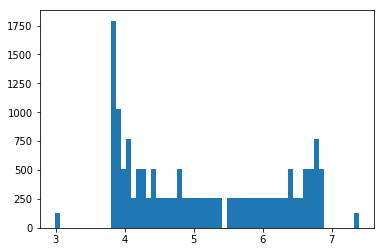

In [161]:
plt.hist(sorted(weight_degree, reverse=True),60)

In [148]:
np.argmin(weight_degree)

9

In [172]:
import pygsp as pg

In [173]:
def sphere_coords(bw, type='DH', dtype=np.float32):
    beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
    beta = beta[1:]
    alpha = np.arange(2 * bw) * np.pi / bw
    theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
    ct = np.cos(theta)
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    x = st * cp
    y = st * sp
    z = ct
    coords = np.vstack([x.flatten(), y.flatten(), z.flatten()]).transpose() 
    coords = np.asarray(coords, dtype=dtype)
    coords = np.vstack([[0., 0., 1.],coords])
    return coords

In [174]:
coords = sphere_coords(2)

In [175]:
G = pg.graphs.NNGraph(coords, k=6)

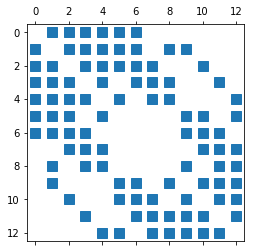

In [176]:
plt.spy(G.W)

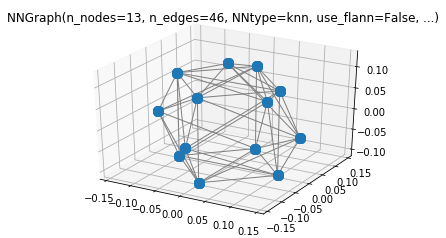

In [177]:
G.plot()

(array([2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 4.]),
 array([3.44317554, 3.47595171, 3.50872788, 3.54150405, 3.57428022,
        3.60705639, 3.63983256, 3.67260873, 3.7053849 , 3.73816107,
        3.77093724, 3.80371341, 3.83648958, 3.86926575, 3.90204192,
        3.93481809, 3.96759426, 4.00037043, 4.0331466 , 4.06592277,
        4.09869894, 4.13147511, 4.16425128, 4.19702745, 4.22980362,
        4.26257979, 4.29535596, 4.32813213, 4.3609083 , 4.39368447,
        4.42646064, 4.45923681, 4.49201298, 4.52478915, 4.55756532,
        4.59034149, 4.62311766, 4.65589383, 4.68867001, 4.72144618,
        4.75422235, 4.78699852, 4.81977469, 4.85255086, 4.88532703,
        4.9181032 , 4.95087937, 4.98365554, 5.01643171, 5.04920788,
        5.08198405, 5.11476022, 5.14753639, 5.

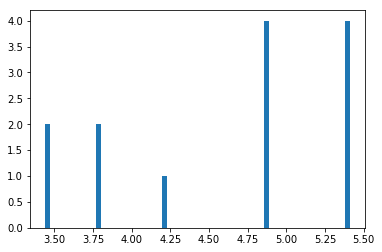

In [180]:
plt.hist(sorted(G.dw, reverse=True),60)

In [235]:
G.W.A

array([[0.        , 0.5       , 0.        , 0.        ],
       [0.5       , 1.        , 0.33409767, 0.33409767],
       [0.        , 0.33409767, 0.        , 0.        ],
       [0.        , 0.33409767, 0.        , 0.        ]])

Try to do a icosahedron graph on the sphere
Realize later that it is Healpix sampling really

In [8]:
import healpy as hp
coords = hp.pix2vec(1,np.arange(12))
coords = np.asarray(coords).T

In [29]:
import pygsp as pg
G = pg.graphs.NNGraph(coords, k=6)

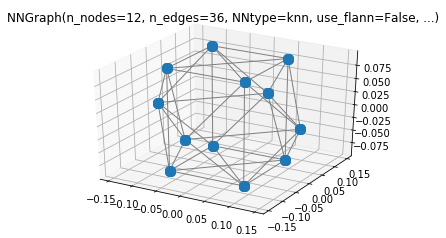

In [30]:
G.plot()

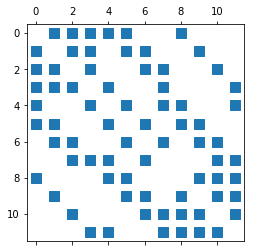

In [31]:
plt.spy(G.W)

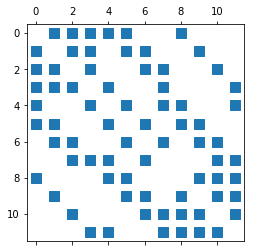

In [32]:
W2 = healpix_weightmatrix(1, True)
plt.spy(W2)

In [33]:
from SHREC17.load_shrec import plot_healpix_projection

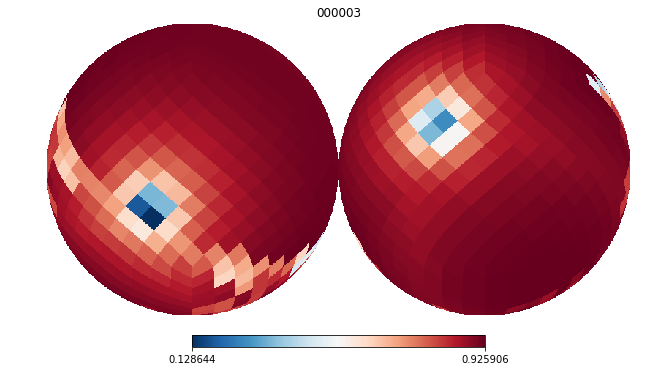

In [169]:
im1=plot_healpix_projection('../data/shrec17/train_perturbed/000003.obj',8,None, False)

In [152]:
im1[np.where(im1==0.)]=np.nan

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/healpy/projaxes.py:1053: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/healpy/projaxes.py:1054: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


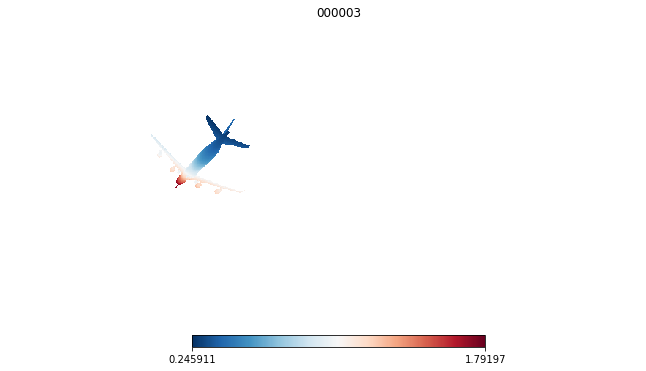

In [51]:
cm = plt.cm.RdBu_r
cm.set_under('w')
cmin = np.nanmin(im1)
cmax = np.nanmax(im1)
hp.orthview(im1, title='000003', nest=True, cmap=cm, min=cmin, max=cmax)

In [161]:
indexes = np.where(np.invert(np.isnan(im1)))[0]
npix = len(indexes)